In [1]:
import math
import numpy as np
import json
import pandas as pd
import glob

from src.constants import OUTPUTS_DIR

In [7]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table_bcjr_lr_search.json"

exp_files = [experiment_file_1]

In [8]:
training_runs = []
validation_runs = []
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
            
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])
        validation_results = pd.DataFrame([{**res, "step": (d["results"][i-1]["step"] + 1 if i > 0 else 0)} for i, res in enumerate(d["results"]) if res["type"] == "validation"])
        preambles = pd.DataFrame([{**d["preamble"]["args"], **d["preamble"]}])
        training_results = training_results.merge(preambles, how="cross")
        validation_results = validation_results.merge(preambles, how="cross")
        
        
        training_runs.append(training_results)
        validation_runs.append(validation_results)

training = pd.concat(training_runs, axis=0)
validation = pd.concat(validation_runs, axis=0)

arg_select_cols = ["adam_lr", "block_len", "snr", "init_method", "window","num_iter", "use_max", "argument_hash"]
training_select_cols = ["xe", "ber", "bler", "step"]
val_select_cols = ["xe__mean", "ber__mean", "bler__mean", "xe__err", "ber__err", "bler__err", "step", ]

training = training[training_select_cols + arg_select_cols]
validation = validation[val_select_cols + arg_select_cols]

lr_filter = [0.01]
training = training[training["adam_lr"].isin(lr_filter)]
validation = validation[validation["adam_lr"].isin(lr_filter)]

display(training.head())
display(validation.head())

,xe,ber,bler,step,adam_lr,block_len,snr,init_method,window,num_iter,use_max,argument_hash
0,0.060050,0.022598,0.537109,0,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
1,0.062037,0.023965,0.553711,1,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
2,0.056301,0.020566,0.527344,2,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
3,0.054322,0.020293,0.516602,3,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
4,0.057531,0.021543,0.547852,4,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f


,xe__mean,ber__mean,bler__mean,xe__err,ber__err,bler__err,step,adam_lr,block_len,snr,init_method,window,num_iter,use_max,argument_hash
0,0.058408,0.022145,0.544141,0.001543,0.000592,0.009844,0,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
1,0.025918,0.009412,0.270898,0.001135,0.000407,0.008784,50,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
2,0.017511,0.006145,0.187598,0.001076,0.000335,0.007716,100,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
3,0.013563,0.004865,0.145605,0.000890,0.000315,0.006971,150,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f
4,0.011233,0.003893,0.119434,0.000821,0.000274,0.006410,200,0.01,50,2.0,normal,5,1,True,7900ede30868bd1da517307e8bd0e6b3d9bbb37f


/tmp/ipykernel_12764/325044493.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


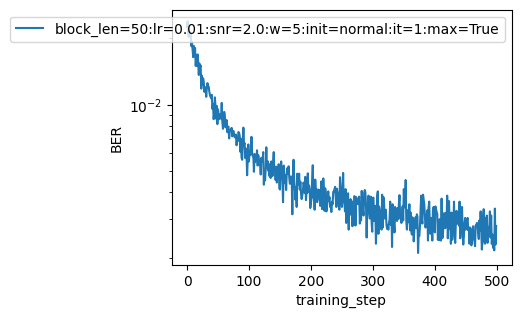

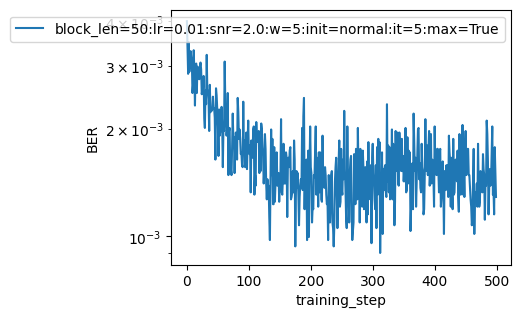

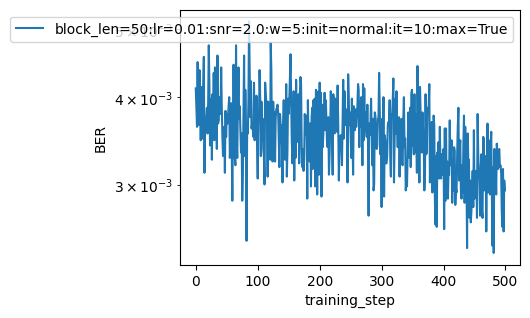

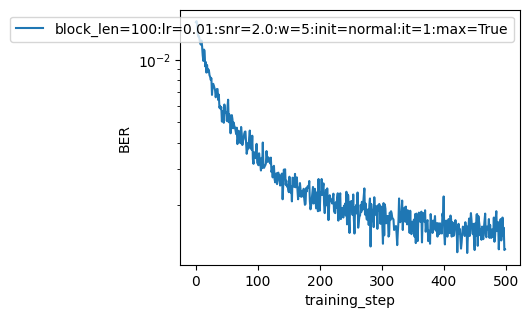

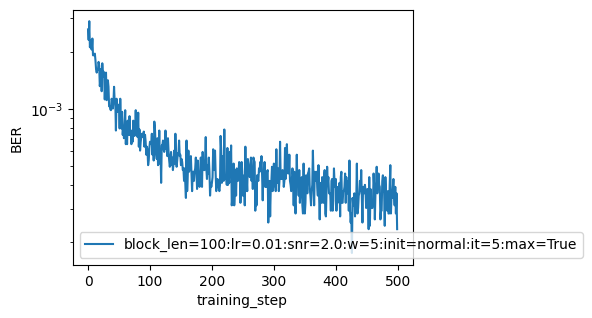

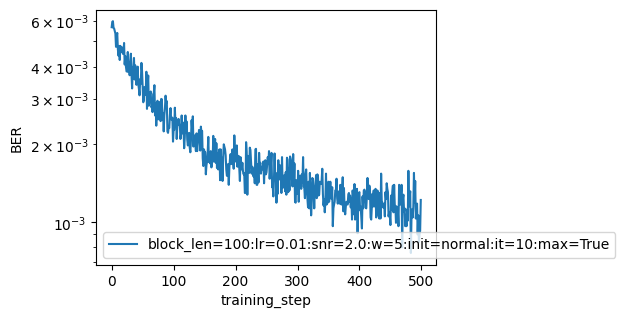

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, snr, window, init_method, num_iter, use_max, argument_hash), training_result in training.groupby(["adam_lr", "block_len", "snr", "window", "init_method", "num_iter", "use_max", "argument_hash"]):
    if len(training_result) < 100:
        continue
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    
    ax.errorbar(
        training_result["step"], 
        training_result["ber"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:lr={lr}:snr={snr}:w={window}:init={init_method}:it={num_iter}:max={use_max}"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('BER')

    fig.show()